In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as distrib
import torch.distributions.transforms as transform

import numpy as np
import matplotlib.pyplot as plt

A demonstration of functions and transformations in pyTorch Module

In [2]:
# Define grid for 2D plotting
x = np.linspace(-4, 4, 1000)
z = np.array(np.meshgrid(x, x)).transpose(1, 2, 0)
z = np.reshape(z, [z.shape[0] * z.shape[1], -1])
z_torch = torch.tensor(z, dtype=torch.float32)

# Univariate Normal
n = distrib.Normal(0, 1)
samples = n.sample((1000,))
density = torch.exp(n.log_prob(torch.tensor(x, dtype=torch.float32))).numpy()

Text(0.5, 1.0, 'True density')

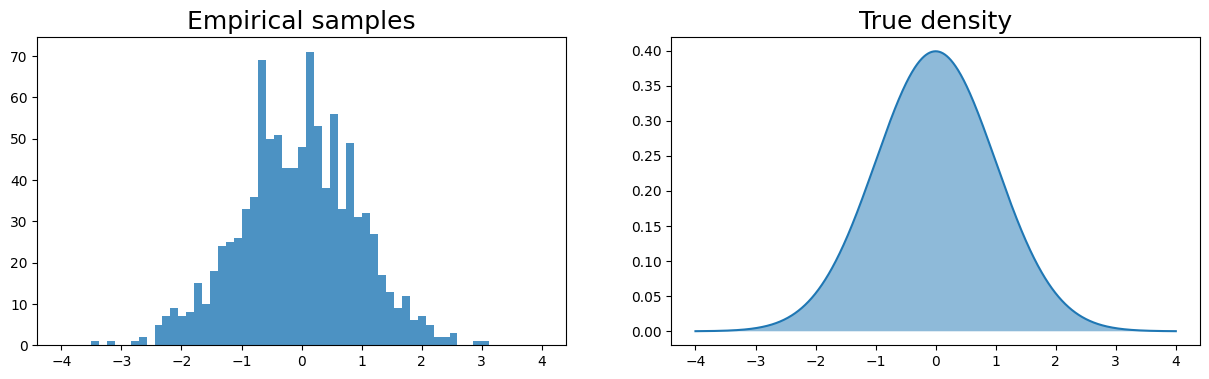

In [3]:
radialfig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(15, 4))
ax1.hist(samples.numpy(), bins=50, alpha=0.8)
ax1.set_title('Empirical samples', fontsize=18)
ax2.plot(x, density)
ax2.fill_between(x, density, 0, alpha=0.5)
ax2.set_title('True density', fontsize=18)

Text(0.5, 1.0, '$q_1=\\exp(q_0)$')

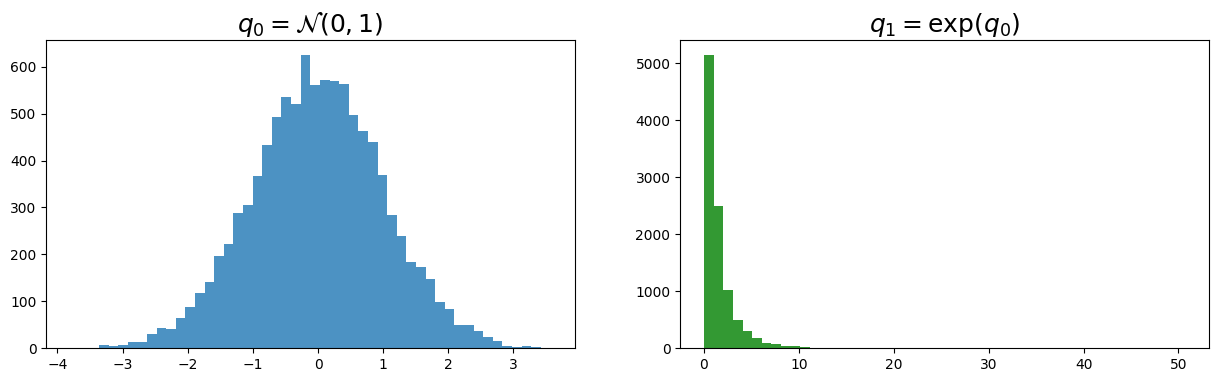

In [4]:
# Transformed distribution: q1 = exp(N(0,1))
q0 = distrib.Normal(0, 1)
exp_t = transform.ExpTransform()
q1 = distrib.TransformedDistribution(q0, [exp_t])

samples_q0 = q0.sample((int(1e4),))
samples_q1 = q1.sample((int(1e4),))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
ax1.hist(samples_q0.numpy(), bins=50, alpha=0.8)
ax1.set_title('$q_0 = \mathcal{N}(0,1)$', fontsize=18)
ax2.hist(samples_q1.numpy(), bins=50, alpha=0.8, color='g')
ax2.set_title('$q_1=\\exp(q_0)$', fontsize=18)

Text(0.5, 1.0, '$q_1=\\exp(q_0)$')

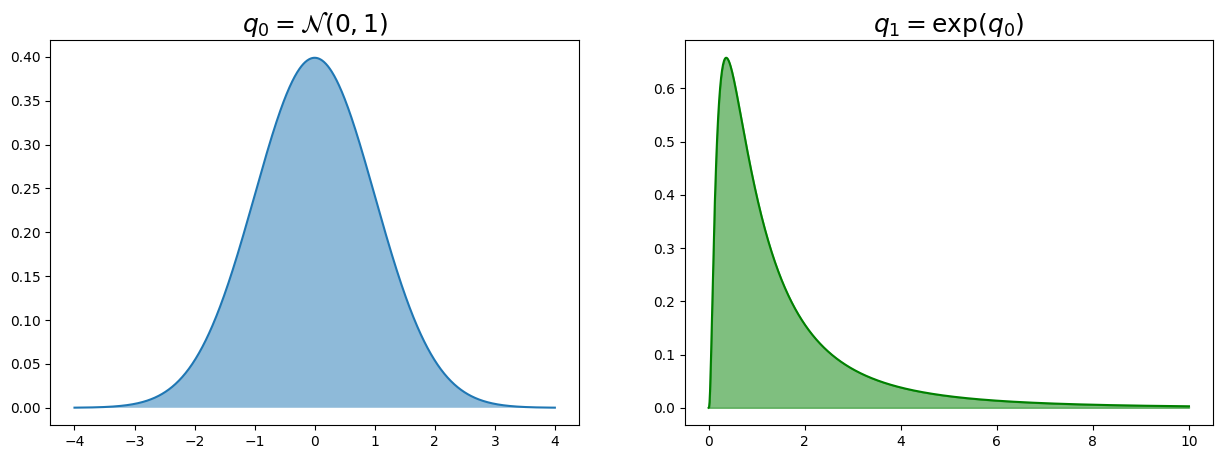

In [5]:
# Plot density of q0 and q1
x_pos = np.linspace(0.001, 10, 1000)
q0_density = torch.exp(q0.log_prob(torch.tensor(x, dtype=torch.float32))).numpy()
q1_density = torch.exp(q1.log_prob(torch.tensor(x_pos, dtype=torch.float32))).numpy()

fig, (ax1, ax2) = plt.subplots(1, 2, sharex=False, figsize=(15, 5))
ax1.plot(x, q0_density)
ax1.fill_between(x, q0_density, 0, alpha=0.5)
ax1.set_title('$q_0 = \mathcal{N}(0,1)$', fontsize=18)

ax2.plot(x_pos, q1_density, color='g')
ax2.fill_between(x_pos, q1_density, 0, alpha=0.5, color='g')
ax2.set_title('$q_1=\\exp(q_0)$', fontsize=18)

Moving on to 2D Transformations

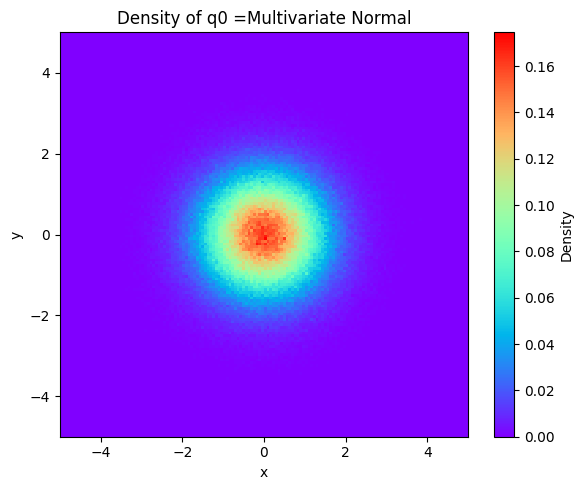

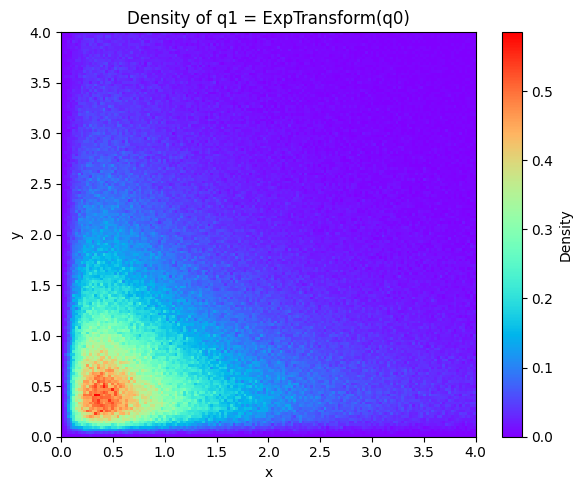

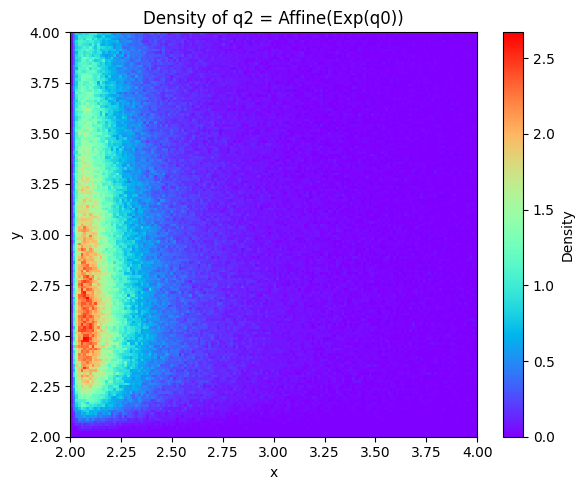

In [6]:
from torch.distributions import MultivariateNormal, TransformedDistribution, transforms as T

# Base distribution
q0 = MultivariateNormal(torch.zeros(2), torch.eye(2))

# Transforms
f1 = T.ExpTransform()
q1 = TransformedDistribution(q0, f1)

#f2 = T.AffineTransform(loc=torch.tensor([0.2, 2.0]), scale=torch.tensor([2.0, 2.0]))
f2 = T.AffineTransform(2, torch.Tensor([0.2, 1.5]))
q2 = TransformedDistribution(q0, [f1, f2])

# Plot samples as 2D histograms (density estimate)
def plot_samples(dist, title, bins=150, range=None):
    samples = dist.sample((1000000,)).numpy()

    plt.figure(figsize=(6, 5))
    plt.hist2d(samples[:, 0], samples[:, 1], bins=bins, density=True, cmap="rainbow", range=range)
    plt.colorbar(label='Density')
    plt.title(title)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.tight_layout()
    plt.show()

# Plot all three
plot_samples(q0, "Density of q0 =Multivariate Normal", range=[[-5, 5], [-5, 5]])
plot_samples(q1, "Density of q1 = ExpTransform(q0)", range=[[0, 4], [0, 4]])
plot_samples(q2, "Density of q2 = Affine(Exp(q0))", range=[[2, 4], [2, 4]])

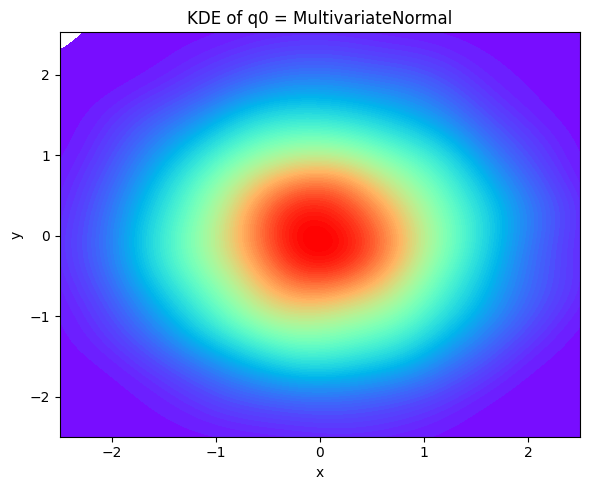

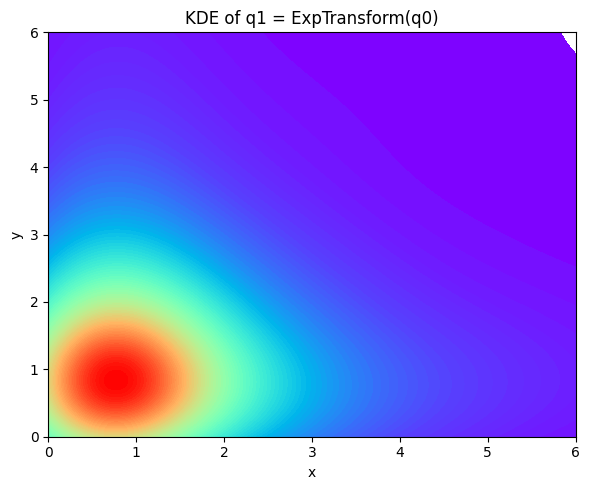

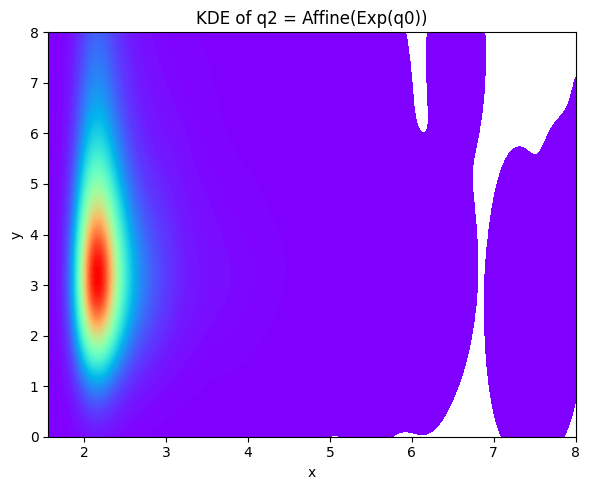

In [7]:
import seaborn as sns

# Base distribution
q0 = MultivariateNormal(torch.zeros(2), torch.eye(2))
f1 = T.ExpTransform()
q1 = TransformedDistribution(q0, f1)
#f2 = T.AffineTransform(loc=torch.tensor([0.2, 1.5]), scale=torch.tensor([2.0, 2.0]))
f2 = T.AffineTransform(2, torch.Tensor([0.2, 1.5]))
q2 = TransformedDistribution(q0, [f1, f2])

# KDE plotter
def plot_kde(dist, title, clip=None):
    samples = dist.sample((10000,)).numpy()

    plt.figure(figsize=(6, 5))
    sns.kdeplot(
        x=samples[:, 0],
        y=samples[:, 1],
        fill=True,
        cmap="rainbow",
        levels=100,
        thresh=1e-5,
        clip=clip,
        bw_adjust=1.5
    )
    plt.title(title)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.tight_layout()
    plt.show()

# Plot all 3
plot_kde(q0, "KDE of q0 = MultivariateNormal", clip=[(-2.5, 2.5), (-2.5, 2.53)])
plot_kde(q1, "KDE of q1 = ExpTransform(q0)", clip=[(0, 6), (0, 6)])
plot_kde(q2, "KDE of q2 = Affine(Exp(q0))", clip=[(0, 8), (0, 8)])


Let's Begin with Flows. Restart the Kernal Before we proceed.

In [8]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from torch.distributions import MultivariateNormal, TransformedDistribution, constraints, Transform
import torch.nn as nn
import torch.distributions as distrib
import torch.distributions.transforms as transform
# Imports for plotting
import numpy as np
import matplotlib.pyplot as plt

In [9]:
# Define Planar Flow Transform
class PlanarFlow(Transform):
    domain = constraints.real
    codomain = constraints.real
    bijective = False
    event_dim = 1

    def __init__(self, weight, scale, bias):
        super().__init__()
        self.weight = weight  # shape: (1, D)
        self.scale = scale    # shape: (1, D)
        self.bias = bias      # shape: (1,) or scalar

    def _call(self, z):
        f_z = F.linear(z, self.weight, self.bias)
        return z + self.scale * torch.tanh(f_z)

    def log_abs_det_jacobian(self, z, y=None):
        f_z = F.linear(z, self.weight, self.bias)
        tanh_prime = 1 - torch.tanh(f_z) ** 2
        psi = tanh_prime * self.weight
        dot = torch.einsum('nd,nd->n', psi, self.scale)
        return torch.log(torch.abs(1 + dot) + 1e-7)

In [10]:
# Define weights
w = torch.tensor([[3., 0.]])
u = torch.tensor([[2., 0.]])
b = torch.tensor([0.])

# Base and transformed distributions
q0 = MultivariateNormal(torch.zeros(2), torch.eye(2))
flow = PlanarFlow(weight=w, scale=u, bias=b)
q1 = TransformedDistribution(q0, flow)

# Sample
z = q0.sample((100000,))        # from base
q1_samples = q1.sample((100000,))  # from flow-transformed

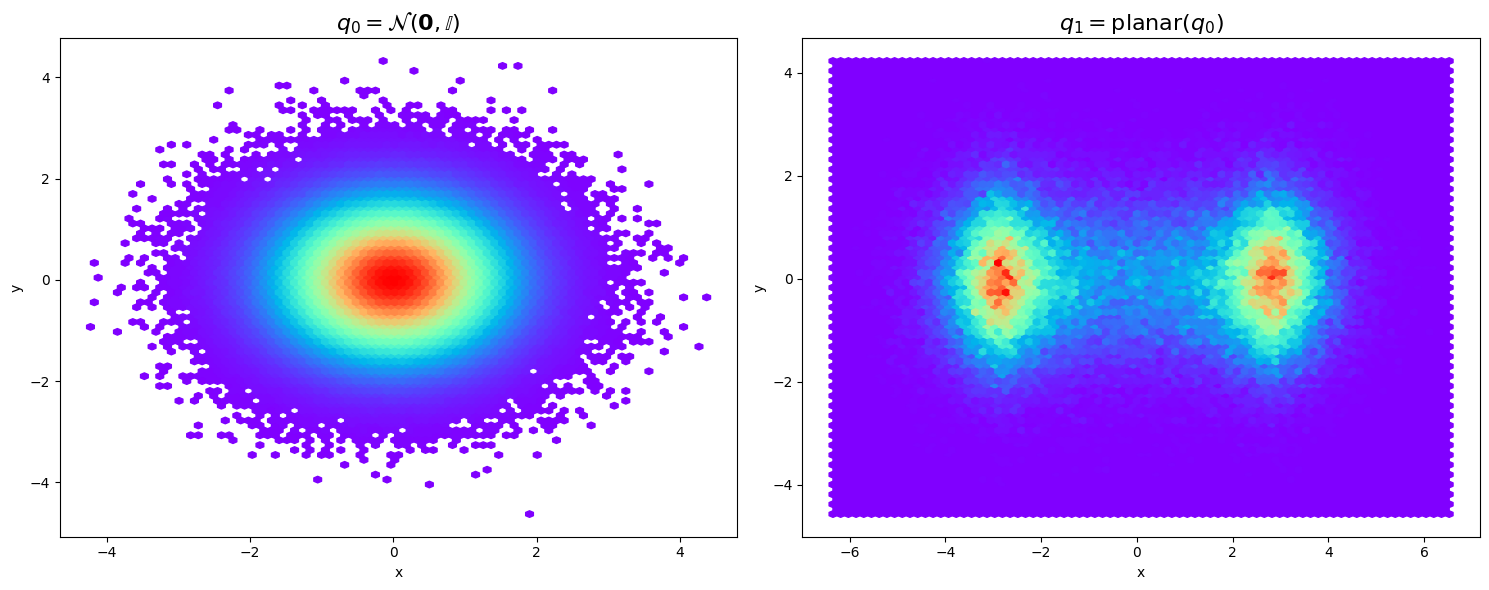

In [11]:
# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# q0 plot
ax1.hexbin(z[:, 0], z[:, 1], C=torch.exp(q0.log_prob(z)), gridsize=80, cmap='rainbow')
ax1.set_title(r'$q_0 = \mathcal{N}(\mathbf{0}, \mathbb{I})$', fontsize=16)
ax1.set_xlabel('x')
ax1.set_ylabel('y')

# q1 plot
ax2.hexbin(q1_samples[:, 0], q1_samples[:, 1], gridsize=80, cmap='rainbow')
ax2.set_title(r'$q_1 = \mathrm{planar}(q_0)$', fontsize=16)
ax2.set_xlabel('x')
ax2.set_ylabel('y')

plt.tight_layout()
plt.show()

The Flow class is:


*   a PyTorch module with invertible transformation behavior (for use in normalizing flows),
*   initialized with small random weights,
*   made hashable so it can be used in sets or as keys in dictionaries.

In [12]:
class Flow(transform.Transform, nn.Module):

    def __init__(self):
        transform.Transform.__init__(self)
        nn.Module.__init__(self)

    # Init all parameters
    def init_parameters(self):
        for param in self.parameters():
            param.data.uniform_(-0.01, 0.01)

    # Hacky hash bypass
    def __hash__(self):
        return nn.Module.__hash__(self)

we implemented the planar flow proposed in the original paper by Rezende [1], which is defined as a function of the form:

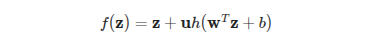



and where the determinant of the Jacobian can be obtained through


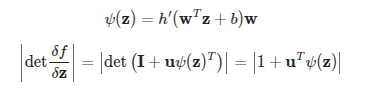



This led to our first implementation of the PlanarFlow. Note here that we added a little bonus that we can change the non-linearity h used in the flow directly in its initialization.

In [13]:
class PlanarFlow(Flow):
    domain = constraints.real
    codomain = constraints.real
    bijective = False
    event_dim = 1
    def __init__(self, dim, h=torch.tanh, hp=(lambda x: 1 - torch.tanh(x) ** 2)):
        super(PlanarFlow, self).__init__()
        self.weight = nn.Parameter(torch.Tensor(1, dim))
        self.scale = nn.Parameter(torch.Tensor(1, dim))
        self.bias = nn.Parameter(torch.Tensor(1))
        self.h = h
        self.hp = hp
        self.init_parameters()

    def _call(self, z):
        f_z = F.linear(z, self.weight, self.bias)
        return z + self.scale * self.h(f_z)

    def log_abs_det_jacobian(self, z):
        f_z = F.linear(z, self.weight, self.bias)
        psi = self.hp(f_z) * self.weight
        det_grad = 1 + torch.mm(psi, self.scale.t())
        return torch.log(det_grad.abs() + 1e-9)

In [14]:
def change_density(q0_density, flow, z):
    # Apply our transform on coordinates
    f_z = flow(torch.Tensor(z)).detach()
    # Obtain our density
    q1_density = q0_density.squeeze() / np.exp(flow.log_abs_det_jacobian(torch.Tensor(z)).detach().squeeze())
    return q1_density, f_z

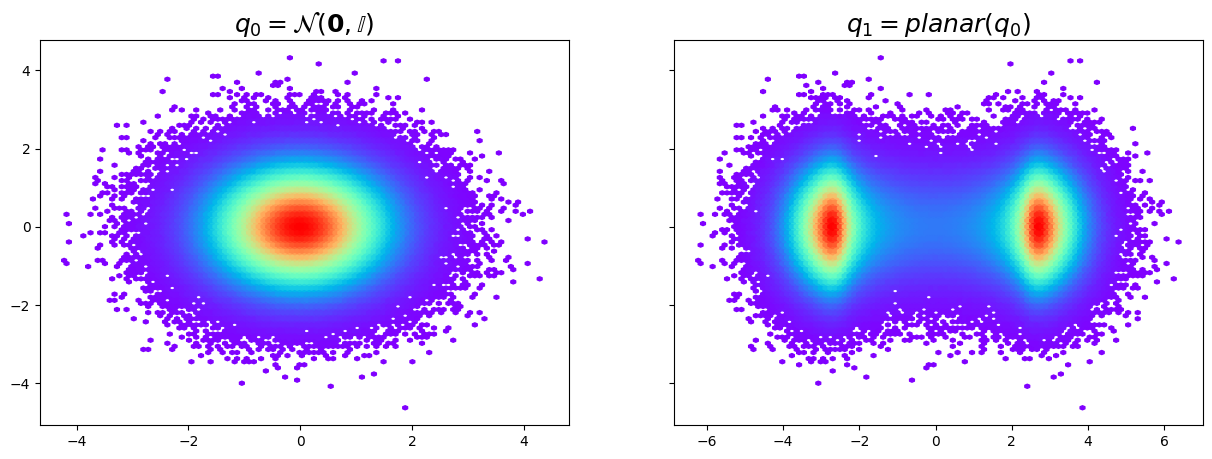

In [15]:
# Our base density
q0 = distrib.MultivariateNormal(torch.zeros(2), torch.eye(2))
q0_density = torch.exp(q0.log_prob(torch.Tensor(z)))
# Our transform
flow = PlanarFlow(2)
# Manually set the transform parameters
flow.weight.data = torch.Tensor([[4, 0]])
flow.scale.data = torch.Tensor([[2, 0]])
flow.bias.data = torch.Tensor([0])
q1_density, f_z = change_density(q0_density, flow, z)
# Plot this
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(15, 5))
ax1.hexbin(z[:,0], z[:,1], C=q0_density.numpy().squeeze(), cmap='rainbow')
ax1.set_title('$q_0 = \mathcal{N}(\mathbf{0},\mathbb{I})$', fontsize=18);
ax2.hexbin(f_z[:,0], f_z[:,1], C=q1_density.numpy().squeeze(), cmap='rainbow')
ax2.set_title('$q_1=planar(q_0)$', fontsize=18);

<a id="recap"></a>
# Radial flow

We will start our tour of different types of flows recently introduced by re-implementing the *radial flow*, proposed in the original paper by Rezende [1]. This family of transformations aim to modify the initial density $q_0$ around a reference point $\mathbf{z}_0$

   $$
   f(\mathbf{z})=\mathbf{z}+\beta h(\alpha,r)(\mathbf{z}-\mathbf{z}_0)
   \tag{7}
   $$

   where $\beta$ is a scalar, $\alpha$ is a positive scalar $r=\left\lVert\mathbf{z}-\mathbf{z}_0\right\rVert$ and $h(\alpha,r)=1/(\alpha+r)$. As recalled in the beginning of the tutorial, in order to obtain the actual density of $f(\mathbf{z})$, we need to compute the determinant of the Jacobian $\left|\det\frac{\partial f}{\partial \mathbf{z}}\right|$. This can be computed as follows (the full derivation once again relies on the matrix determinant lemma, for a full

$$
\left|\det\frac{\partial f}{\partial \mathbf{z}}\right| = \left(1 + \beta h(\alpha,r) + \beta h'(\alpha,r)r\right)(1+\beta h(\alpha,r))^{d-1}
\tag{8}
$$
   
This type of flow also provides a computation of the determinant in $O(D)$, but applies radial contractions and expansions around the reference point (hence the name *radial
flows*). Here, we will implement the `RadialFlow` by following our previously defined `Flow` class

In [17]:
class RadialFlow(Flow):

    def __init__(self, dim):
        super(RadialFlow, self).__init__()
        self.z0 = nn.Parameter(torch.Tensor(1, dim))
        self.alpha = nn.Parameter(torch.Tensor(1, dim))
        self.beta = nn.Parameter(torch.Tensor(1, dim))
        self.dim = dim
        self.init_parameters()

    def _call(self, z):
        r = torch.norm(z - self.z0, dim=1, keepdim=True)
        return z + self.alpha * (r ** self.beta) * (z - self.z0) / (r + 1e-9)


    def log_abs_det_jacobian(self, z):
        r = torch.norm(z - self.z0, dim=1, keepdim=True)
        r = r + 1e-9
        d = z - self.z0
        d = d / r
        alpha = self.alpha * (r ** (self.beta - 1))
        beta = self.beta * (r ** (self.beta - 1))
        det_grad = 1 + torch.sum(alpha * d, dim=1, keepdim=True)
        return torch.log(det_grad.abs() + 1e-9)


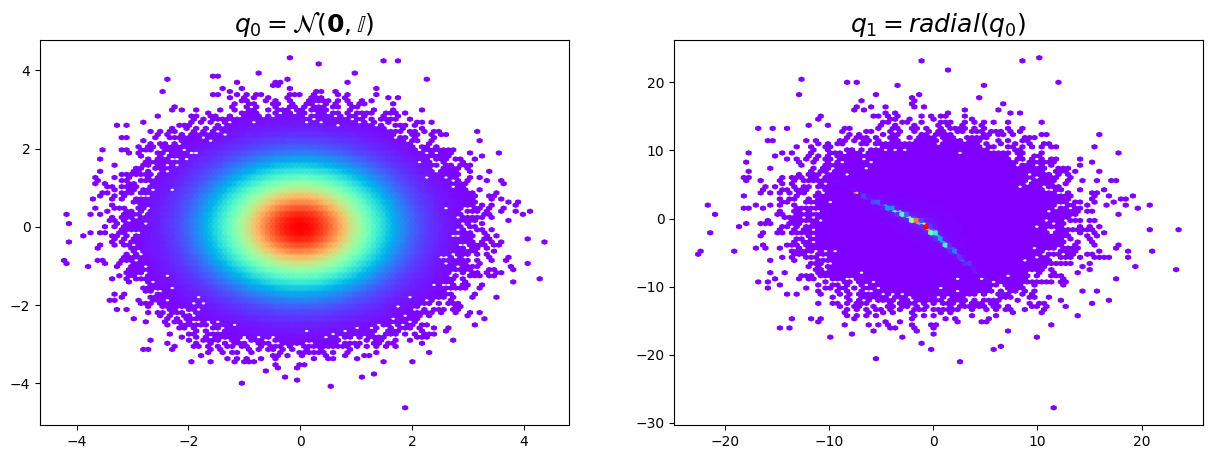

In [ ]:
# Our base density
q0 = distrib.MultivariateNormal()
q0_density = torch.exp()
# Our transform
flow = RadialFlow(2)

flow.z0.data = torch.Tensor([[0, 0]])
flow.alpha.data = torch.Tensor([[1, 1]])
flow.beta.data = torch.Tensor([[2, 2]])
q1_density, f_z = change_density(q0_density, flow, z)
# Plot this
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.hexbin(z[:,0], z[:,1], C=q0_density.numpy().squeeze(), cmap='rainbow')
ax1.set_title('$q_0 = \mathcal{N}(\mathbf{0},\mathbb{I})$', fontsize=18);
ax2.hexbin(f_z[:,0], f_z[:,1], C=q1_density.numpy().squeeze(), cmap='rainbow')
ax2.set_title('$q_1=radial(q_0)$', fontsize=18);

In [ ]:
class BatchNormFlow(Flow):

    domain = constraints.real
    codomain = constraints.real
    bijective = False
    event_dim = 1

    def __init__(self, dim, momentum=0.95, eps=1e-5):
        super(BatchNormFlow, self).__init__()
        # Running batch statistics
        self.r_mean = torch.zeros(dim)
        self.r_var = torch.ones(dim)
        # Momentum
        self.momentum = momentum
        self.eps = eps
        # Trainable scale and shift (cf. original paper)
        self.gamma = nn.Parameter(torch.ones(dim))
        self.beta = nn.Parameter(torch.zeros(dim))

    def _call(self, z):
        if self.training:
            # Current batch stats
            self.b_mean = z.mean(0)
            self.b_var = (z - self.b_mean).pow(2).mean(0) + self.eps
            # Running mean and var
            self.r_mean = self.momentum * self.r_mean + ((1 - self.momentum) * self.b_mean)
            self.r_var = self.momentum * self.r_var + ((1 - self.momentum) * self.b_var)
            mean = self.b_mean
            var = self.b_var
        else:
            mean = self.r_mean
            var = self.r_var
        x_hat = (z - mean) / var.sqrt()
        y = self.gamma * x_hat + self.beta
        return y

    def _inverse(self, x):
        if self.training:
            mean = self.b_mean
            var = self.b_var
        else:
            mean = self.r_mean
            var = self.r_var
        x_hat = (z - self.beta) / self.gamma
        y = x_hat * var.sqrt() + mean
        return y

    def log_abs_det_jacobian(self, z):
        # Here we only need the variance
        mean = z.mean(0)
        var = (z - mean).pow(2).mean(0) + self.eps
        log_det = torch.log(self.gamma) - 0.5 * torch.log(var + self.eps)
        return torch.sum(log_det, -1)

In [ ]:
# Define grids of points (for later plots)
x = np.linspace(-4, 4, 1000)
z = np.array(np.meshgrid(x, x)).transpose(1, 2, 0)
z = np.reshape(z, [z.shape[0] * z.shape[1], -1])

In [ ]:
# Our base density
q0 = distrib.MultivariateNormal(torch.zeros(2), torch.eye(2))
q0_density = torch.exp(q0.log_prob(torch.Tensor(z)))
# Our BatchNorm transform
flow = BatchNormFlow(2)
flow.momentum = torch.Tensor([1000])
flow.r_mean = torch.Tensor([[3.0,5.0]])

q1_density, f_z = change_density(q0_density, flow, z)

# Plot this
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.hexbin(z[:,0], z[:,1], C=q0_density.numpy().squeeze(), cmap='rainbow')
ax1.set_title('$q_0 = \mathcal{N}(\mathbf{0},\mathbb{I})$', fontsize=18);
ax2.set_xlim([-4, 4])
ax2.set_ylim([-4, 4])
ax2.hexbin(f_z[:,0], f_z[:,1], C=q1_density.numpy().squeeze(), cmap='rainbow')
ax2.set_title('$q_1=BatchNorm(q_0)$', fontsize=18);


#### Parametric ReLU flow
Although this is very similar to the base ReLU (and is more generally a form of Leaky ReLU), it comes with the added bonus of having a trainable parameters. The PReLU is defined as

$$
\text{PReLU}\left(x\right)=
\begin{cases}
    x,& \text{if } x > 0\\
    \alpha . x,              & \text{otherwise}
\end{cases}
$$

The first advantage of this non-linearity is that its derivative is extremely simple. And as we have just seen for element-wise operations, we can obtain the log-determinant of its Jacobian simply as

$$
\text{log }\left|\det{\frac{\partial f}{\partial \mathbf{x}}}\right| = \sum_{i=1}^D \text{log }\left|
\begin{cases}
    1,& \text{if } x > 0\\
    \alpha ,              & \text{otherwise}
\end{cases}
\right|
$$

The second advantage of the PReLU is that it is now also invertible and we can define

$$
\text{PReLU}^{-1}\left(x\right)=
\begin{cases}
    x,& \text{if } x > 0\\
    \frac{1}{\alpha} . x,              & \text{otherwise}
\end{cases}
$$

Hence, we have all the elements to consider this transform as a flow, and we define here the `PReLUFlow` following our base architecture.

In [ ]:
# Flow version of Leaky ReLU
class PReLUFlow(Flow):
    domain = constraints.real
    codomain = constraints.real
    bijective = False
    event_dim = 1

    def __init__(self, dim):
        super(PReLUFlow, self).__init__()
        self.alpha = nn.Parameter(torch.Tensor([1]))
        self.bijective = True

    def init_parameters(self):
        for param in self.parameters():
            param.data.uniform_(0.01, 0.99)

    def _call(self, z):
        return torch.where(z >= 0, z, torch.abs(self.alpha) * z)

    def _inverse(self, z):
        return torch.where(z >= 0, z, torch.abs(1. / self.alpha) * z)

    def log_abs_det_jacobian(self, z):
        I = torch.ones_like(z)
        J = torch.where(z >= 0, I, self.alpha * I)
        log_abs_det = torch.log(torch.abs(J) + 1e-5)
        return torch.sum(log_abs_det, dim = 1)

In [ ]:
# Our base density
q0 = distrib.MultivariateNormal(torch.zeros(2), torch.eye(2))
q0_density = torch.exp(q0.log_prob(torch.Tensor(z)))

# Our Batchnorm transform
flow = BatchNormFlow(2)

q1_density, f_z = change_density(q0_density, flow, z)
# Our ReLU flow
flow = PReLUFlow(2)
# Manually set the transform parameters (dirty again ^^)
flow.alpha.data = torch.Tensor([0.5])
q2_density, f_z2 = change_density(q1_density, flow, f_z)

# Plot this
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
ax1.hexbin(z[:,0], z[:,1], C=q0_density.numpy().squeeze(), cmap='rainbow')
ax1.set_title('$q_0 = \mathcal{N}(\mathbf{0},\mathbb{I})$', fontsize=18);
ax2.hexbin(f_z[:,0], f_z[:,1], C=q1_density.numpy().squeeze(), cmap='rainbow')
ax2.set_title('$q_1=BatchNorm(q_0)$', fontsize=18);
ax3.hexbin(f_z2[:,0], f_z2[:,1], C=q2_density.numpy().squeeze(), cmap='rainbow')
ax3.set_title('$q_2=PReLU(q_1)$', fontsize=18);

In [ ]:
## Flow version of affine transform
class AffineFlow(Flow):
    domain = constraints.real
    codomain = constraints.real
    bijective = False
    event_dim = 1

    def __init__(self, dim):
        super(AffineFlow, self).__init__()
        self.weights = nn.Parameter(torch.Tensor(dim, dim))
        nn.init.orthogonal_(self.weights)

    def _call(self, z):
        return z @ self.weights

    def _inverse(self, z):
        return z @ torch.inverse(self.weights)

    def log_abs_det_jacobian(self, z):
        return torch.slogdet(self.weights)[-1].unsqueeze(0).repeat(z.size(0), 1)

In [ ]:
from scipy import linalg as splin
## Affine Flow with LU decomposition
class AffineLUFlow(Flow):
    domain = constraints.real
    codomain = constraints.real
    bijective = False
    event_dim = 1
    def __init__(self, dim):
        super(AffineLUFlow, self).__init__()
        weights = torch.Tensor(dim, dim)
        nn.init.orthogonal_(weights)
        # Compute the parametrization
        P, L, U = splin.lu(weights.numpy())
        self.P = torch.Tensor(P)
        self.L = nn.Parameter(torch.Tensor(L))
        self.U = nn.Parameter(torch.Tensor(U))
        # Need to create masks for enforcing triangular matrices
        self.mask_low = torch.tril(torch.ones(weights.size()), -1)
        self.mask_up = torch.triu(torch.ones(weights.size()), -1)
        self.I = torch.eye(weights.size(0))
        # Now compute s
        self.s = nn.Parameter(torch.Tensor(np.diag(np.array(U))))

    def _call(self, z):
        L = self.L * self.mask_low + self.I
        U = self.U * self.mask_up + torch.diag(self.s)
        weights = self.P @ L @ U
        return z @ weights

    def _inverse(self, z):
        L = self.L * self.mask_low + self.I
        U = self.U * self.mask_up + torch.diag(self.s)
        weights = self.P @ L @ U
        return z @ torch.inverse(self.weights)

    def log_abs_det_jacobian(self, z):
        return torch.sum(torch.log(torch.abs(self.s))).unsqueeze(0).repeat(z.size(0), 1)

In [ ]:
# Main class for normalizing flow
class NormalizingFlow(nn.Module):

    def __init__(self, dim, blocks, flow_length, density):
        super().__init__()
        biject = []
        for f in range(flow_length):
            for b_flow in blocks:
                biject.append(b_flow(dim))
        self.transforms = transform.ComposeTransform(biject)
        self.bijectors = nn.ModuleList(biject)
        self.base_density = density
        self.final_density = distrib.TransformedDistribution(density, self.transforms)
        self.log_det = []

    def forward(self, z):
        self.log_det = []
        # Applies series of flows
        for b in range(len(self.bijectors)):
            self.log_det.append(self.bijectors[b].log_abs_det_jacobian(z))
            z = self.bijectors[b](z)
        return z, self.log_det

In [ ]:
# Our MLP blocks
block_mlp = [

]
# Create normalizing flow
flow = NormalizingFlow(dim=2, blocks=block_mlp, flow_length=, density=distrib.MultivariateNormal())

In [ ]:
def density_ring(z):
    z1, z2 = torch.chunk(z, chunks=2, dim=1)
    norm = torch.sqrt(z1 ** 2 + z2 ** 2)
    exp1 = torch.exp(-0.5 * ((z1 - 2) / 0.8) ** 2)
    exp2 = torch.exp(-0.5 * ((z1 + 2) / 0.8) ** 2)
    u = 0.5 * ((norm - 4) / 0.4) ** 2 - torch.log(exp1 + exp2)
    return torch.exp(-u)

# Plot it
x = np.linspace(-5, 5, 1000)
z = np.array(np.meshgrid(x, x)).transpose(1, 2, 0)
z = np.reshape(z, [z.shape[0] * z.shape[1], -1])
plt.hexbin(z[:,0], z[:,1], C=density_ring(torch.Tensor(z)).numpy().squeeze(), cmap='rainbow')
plt.title('Target density', fontsize=18);

In [ ]:
import torch.optim as optim
# Create optimizer algorithm
optimizer = optim.Adam(flow.parameters(), lr=1e-3)
# Add learning rate scheduler
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, 0.99995)
# Define our loss
def loss(density, zk, log_jacobians):
    sum_of_log_jacobians = sum(log_jacobians)
    return (-sum_of_log_jacobians - torch.log(density(zk) + 1e-9)).mean()

In [ ]:
ref_distrib = distrib.MultivariateNormal(torch.zeros(2), torch.eye(2))

In [ ]:
id_figure=1
# Main optimization loop
for it in range(10001):
    # Draw a sample batch from Normal
    samples = ref_distrib.sample((512, ))
    # Evaluate flow of transforms
    zk, log_jacobians = flow(samples)
    # Evaluate loss and backprop
    optimizer.zero_grad()
    loss_v = loss(density_ring, zk, log_jacobians)
    loss_v.backward()
    optimizer.step()
    scheduler.step()
    if (it % 1000 == 0):
        print('Loss (it. %i) : %f'%(it, loss_v.item()))
        # Draw random samples
        samples = ref_distrib.sample((int(1e5), ))
        # Evaluate flow and plot
        zk, _ = flow(samples)
        zk = zk.detach().numpy()
        plt.subplot(3,4,id_figure)
        plt.hexbin(zk[:,0], zk[:,1], cmap='rainbow')
        plt.title('Iter.%i'%(it), fontsize=15);
        id_figure += 1

In [ ]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as distrib
import torch.distributions.transforms as transform
# Imports for plotting
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# Define grids of points (for later plots)
x = np.linspace(-4, 4, 1000)
z = np.array(np.meshgrid(x, x)).transpose(1, 2, 0)
z = np.reshape(z, [z.shape[0] * z.shape[1], -1])

In [ ]:
w1 = lambda z: torch.sin(2 * math.pi * z[:, 0] / 4)
w2 = lambda z: 3 * torch.exp(-0.5 * ((z[:, 0] - 1) / 0.6) ** 2)
w3 = lambda z: 3 * (1.0 / (1 + torch.exp(-(z[:, 0] - 1) / 0.3)))

def density_mvn(z, mu=torch.FloatTensor([[0, 0]]), sig=torch.FloatTensor([[1, 1]])):
    z = z[:, None, :] - mu[None, :, :]
    sig_inv = 1./sig
    exponent = -0.5 * torch.sum(z * sig_inv[None, :, :] * z, (1, 2))
    return torch.exp(exponent)

def density_bivar(z):
    add1 = 0.5 * ((torch.norm(z, 2, 1) - 2) / 0.4) ** 2
    add2 = -torch.log(torch.exp(-0.5 * ((z[:, 0] - 2) / 0.6) ** 2) + torch.exp(-0.5 * ((z[:, 0] + 2) / 0.6) ** 2))
    return torch.exp(-(add1 + add2))

def density_ring(z):
    z1, z2 = torch.chunk(z, chunks=2, dim=1)
    norm = torch.sqrt(z1 ** 2 + z2 ** 2)
    exp1 = torch.exp(-0.5 * ((z1 - 2) / 0.8) ** 2)
    exp2 = torch.exp(-0.5 * ((z1 + 2) / 0.8) ** 2)
    u = 0.5 * ((norm - 4) / 0.4) ** 2 - torch.log(exp1 + exp2)
    return torch.exp(-u)

def density_wave(z):
    z = torch.reshape(z, [z.shape[0], 2])
    z1, z2 = z[:, 0], z[:, 1]
    u = 0.5 * ((z2 - w1(z))/0.4) ** 2
    u[torch.abs(z1) > 4] = 1e8
    return torch.exp(-u)

def density_wave_twist(z):
    in1 = torch.exp(-0.5 * ((z[:, 1] - w1(z)) / 0.35) ** 2)
    in2 = torch.exp(-0.5 * ((z[:, 1] - w1(z) + w2(z)) / 0.35) ** 2)
    return torch.exp(torch.log(in1 + in2 + 1e-9))

def density_wave_split(z):
    in1 = torch.exp(-0.5 * ((z[:, 1] - w1(z)) / 0.4) ** 2)
    in2 = torch.exp(-0.5 * ((z[:, 1] - w1(z) + w3(z)) / 0.35) ** 2)
    return torch.exp(torch.log(in1 + in2))

def density_circle(z, n_dens=10):
    full_dens = []
    for n in range(n_dens):
        x = math.cos((n / float(n_dens)) * 2 * math.pi) * 3
        y = math.sin((n / float(n_dens)) * 2 * math.pi) * 3
        full_dens.append(density_mvn(z, mu=torch.FloatTensor([[x, y]]), sig= 0.1 * torch.FloatTensor([[1, 2]])).unsqueeze(1))
    return torch.sum(torch.cat(full_dens, dim=1), dim=1)

x = np.linspace(-5, 5, 1000)
z = np.array(np.meshgrid(x, x)).transpose(1, 2, 0)
z = np.reshape(z, [z.shape[0] * z.shape[1], -1])
# Set of target densities
targets = [density_bivar, density_ring, density_wave, density_wave_twist, density_wave_split, density_circle]
# Plot these lads
plt.figure(figsize=(15, 5))
for t in range(len(targets)):
    plt.subplot(1, len(targets), t+1)
    plt.hexbin(z[:,0], z[:,1], C = targets[t](torch.Tensor(z)).numpy().squeeze(), cmap='rainbow')
    plt.title('Target ' + str(t), fontsize=18);

In [ ]:
class Flow(transform.Transform, nn.Module):

    def __init__(self):
        transform.Transform.__init__(self)
        nn.Module.__init__(self)

    # Init all parameters
    def init_parameters(self):
        for param in self.parameters():
            param.data.uniform_(-0.01, 0.01)

    # Hacky hash bypass
    def __hash__(self):
        return nn.Module.__hash__(self)

In [ ]:
import torch.optim as optim
# Define our loss
def loss(density, zk, log_jacobians):
    sum_of_log_jacobians = sum(log_jacobians)
    return (-sum_of_log_jacobians - torch.log(density(zk) + 1e-9)).mean()

In [ ]:
def train_flow(flow, loss, optimizer, scheduler, target_density, epochs=10001, plot_it=1000):
    ref_distrib = distrib.MultivariateNormal(torch.zeros(2), torch.eye(2))
    ims = []
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 7))
    fig = plt.figure(figsize=(10, 10))
    # Main optimization loop
    for it in range(epochs):
        # Draw a sample batch from Normal
        samples = ref_distrib.sample((512, ))
        # Evaluate flow of transforms
        zk, log_jacobians = flow(samples)
        # Evaluate loss and backprop
        #optimizer.zero_grad()
        loss_v = loss(target_density, zk, log_jacobians)
        loss_v.backward()
        optimizer.step()
        scheduler.step()
        if (it % plot_it == 0):
            print('Loss (it. %i) : %f'%(it, loss_v.item()))
            # Draw random samples
            samples = ref_distrib.sample((int(1e5), ))
            # Evaluate flow and plot
            zk, _ = flow(samples)
            zk = zk.detach().numpy()
            im = plt.hexbin(zk[:,0], zk[:,1], cmap='rainbow', animated='True')
            ims.append([im])

    ax1.hexbin(z[:,0], z[:,1], C=target_density(torch.Tensor(z)).numpy().squeeze(), cmap='rainbow')
    ax1.set_title('Target density', fontsize=15);
    ax2.hexbin(zk[:,0], zk[:,1], cmap='rainbow')
    ax2.set_title('Final approximation', fontsize=15)
    # anim = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)
    # HTML(anim.to_html5_video())
    # anim.save("check.mp4")
    ax3.set_title('Optimization process', fontsize=15)

## Real Non-Volume Preserving flows (Real-NVPs)

At the core of the Real-NVP [2] model is the definition of bijectors called *affine coupling layers*. Hence, given an input $\mathbf{z}\in\mathbb{R}^D$, an integer $k$, with $1 < k < D$ and $g_{\mu}:\mathcal{R}^k \mapsto \mathcal{R}^{D-k}$ and $g_{\sigma}:\mathcal{R}^k \mapsto \mathcal{R}^{D-k}$, Real-NVP flows are defined as

$$
  \mathbf{z}'_{1:k} = \mathbf{z}_{1:k},\\
  \mathbf{z}'_{k+1:D} = \mathbf{z}_{k+1:D} \odot exp(g_{\sigma}(\mathbf{z}_{1:k})) + g_{\mu}(\mathbf{z}_{1:k})
\tag{8}
$$

where $\odot$ defines the element-wise multiplication operator. As we can see, this transform copies the $k$ first dimensions and applies a *scale and shift* operation to the remaining $d - k$ dimensions. Therefore, this defines an autoregressive transform, and the Jacobian is defined as an identity matrix $\mathbf{I}_k$ for the $k$ first dimensions. The second part is lower triangular and only contains $exp(g_{\sigma}(\mathbf{z}_{1:k}))$ on its diagonal. Therefore, the log-determinant of the Jacobian is simply

$$
  \text{log }\left|\frac{\partial f(\mathbf{z})}{\partial \mathbf{z}}\right| = \sum_{i=k+1}^{D} \left|g_{\sigma}(\mathbf{z}_{1:k})\right|
\tag{9}
$$

This type of flow is very interesting, as it can be simply implemented and both the sampling and inference can be efficiently performed, as all operations of a flow can be performed in parallel. Furthermore, as detailed in [2], the inverse transform of this flow is also rather simple

$$
\mathbf{z}_{1:k} = \mathbf{z}'_{1:k},\\
\mathbf{z}_{k+1:D} = \frac{\mathbf{z}'_{k+1:D} - g_{\mu}(\mathbf{z}'_{1:k})}{g_\sigma(\mathbf{z}_{1:k})}
\tag{10}
$$

As we explained before, $g_{\mu}$ and $g_{\sigma}$ will be implemented as neural networks, which are usually not invertible. However, we see here that we do not need to invert these but we are still able to have a transform which is globally invertible.

Following our previous formalism, we can easily produce a naive (we will see later why) implementation of this `AffineCouplingFlow`.


In [ ]:
# Affine coupling flow
class AffineCouplingFlow(Flow):
    domain = constraints.real
    codomain = constraints.real
    bijective =
    event_dim = 1

    def __init__(self, dim, n_hidden=64, n_layers=3, activation=nn.ReLU):
        super(AffineCouplingFlow, self).__init__()
        self.k = dim // 2
        self.g_mu = self.transform_net(self.k, dim - self.k, n_hidden, n_layers, activation)
        self.g_sig = self.transform_net(self.k, dim - self.k, n_hidden, n_layers, activation)
        self.init_parameters()
        self.bijective =

    def transform_net(self, nin, nout, nhidden, nlayer, activation):
        net = nn.ModuleList()
        for l in range(nlayer):
            net.append(nn.Linear(l==0 and nin or nhidden, l==nlayer-1 and nout or nhidden))
            net.append(activation())
        return nn.Sequential(*net)

    def _call(self, z):
        z_k, z_D = z[:, :self.k], z[:, self.k:]
        zp_D = z_D * torch.exp(self.g_sig(z_k)) + self.g_mu(z_k)
        return torch.cat((z_k, zp_D), dim = 1)

    def _inverse(self, z):
        zp_k, zp_D = z[:, :self.k], z[:, self.k:]
        z_D = (zp_D - self.g_mu(zp_k)) / self.g_sig(zp_k)
        return torch.cat((zp_k, z_D))

    def log_abs_det_jacobian(self, z):
        z_k = z[:, :self.k]
        return -torch.sum(torch.abs(self.g_sig(z_k)))

In [ ]:
class ReverseFlow(Flow):
    domain = constraints.real
    codomain = constraints.real
    bijective = False
    event_dim = 1
    def __init__(self, dim):
        super(ReverseFlow, self).__init__()
        self.permute = torch.arange(dim-1, -1, -1)
        self.inverse = torch.argsort(self.permute)

    def _call(self, z):
        return z[:, self.permute]

    def _inverse(self, z):
        return z[:, self.inverse]

    def log_abs_det_jacobian(self, z):
        return torch.zeros(z.shape[0], 1)

In [ ]:
class ShuffleFlow(ReverseFlow):
    domain = constraints.real
    codomain = constraints.real
    bijective = False
    event_dim = 1
    def __init__(self, dim):
        super(ShuffleFlow, self).__init__(dim)
        self.permute = torch.randperm(dim)
        self.inverse = torch.argsort(self.permute)

In [ ]:
# Our different flow blocks
block_real_nvp = [ ]

In [ ]:
# Create normalizing flow
flow_real_nvp = NormalizingFlow()

In [ ]:
# Create optimizer algorithm
optimizer = optim.Adam(flow_real_nvp.parameters(), lr=1e-3)
# Add learning rate scheduler
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, 0.99995)
# Launch the optimization
train_flow(flow_real_nvp, loss, optimizer, scheduler, density_wave, epochs=150, plot_it=20)

### References

<a id="reference1"></a>
[1] Rezende, Danilo Jimenez, and Shakir Mohamed. "Variational inference with normalizing flows." _arXiv preprint arXiv:1505.05770_ (2015). [link](http://arxiv.org/pdf/1505.05770)

[2] Dinh, L., Sohl-Dickstein, J., & Bengio, S. Density estimation using Real NVP. arXiv preprint arXiv:1605.08803. (2016). [link](https://arxiv.org/abs/1605.08803)